In [128]:
import cobra
import pandas as pd
import re
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
import leakage, utils
import pubchempy as pcp
import seaborn as sns

In [129]:
model = cobra.io.read_sbml_model('../../models/e_coli/momentiJO1366.xml')
model.reactions.DHAPT.knock_out()
model.reactions.THRA.knock_out()
model.reactions.THRA2.knock_out()
model.reactions.F6PA_TG_forward.knock_out()

In [180]:
met_info_df = pd.read_csv("../../data/met_info_curated.csv", encoding = "ISO-8859-1", index_col = 0)

In [181]:
met_info_df.head()

,Metabolite name,Metabolite id,Mass,Charge,Phosphate,Topological Polar Surface Area,Concentration in E.coli,log P
0,Glucose-6-phosphate,g6p,258.119901,-2.0,1,165.0,0.003000,-4.50
1,Fructose-6-phosphate,f6p,258.119901,-2.0,1,165.0,0.003000,-4.30
2,"Fructose-1,6-bisphosphate",fdp,336.083922,-4.0,2,215.0,0.015200,-5.90
3,Dihydroxyacetonephosphate,dhap,168.041961,-2.0,1,104.0,0.000374,-5.90
4,Glyceraldehyde-3-phosphate,g3p,168.041961,-2.0,1,104.0,NaN,-2.75


# Get leakage

In [182]:
time = 6
exometabolites_folder = Path("../../data/e_coli/")
leakage_df = leakage.get_leakage(exometabolites_folder, "ecoli", time = time, unit = '/gDW')
leakage_df.set_index("Metabolite", inplace=True)
leakage_df.drop_duplicates(inplace=True)
leakage_label = "Leakage (mM/gDW/h)"

In [183]:
# Read metabolite mapping
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)
df2 = pd.merge(leakage_df, mapping_df, left_index=True, right_index=True)
df2.drop(columns='Metabolite name', inplace=True)

In [133]:
df = pd.merge(met_info_df, df2, left_on = 'Metabolite id', right_on = 'Ecoli metabolite')

In [185]:
leakage_df

,Leakage (mM/gDW/h)
Metabolite,
G6P,2.112709
F6P,2.310546
FBP,0.022204
DHAP,2.581162
GA3P,0.396769
23PG,0.858594
PEP,0.311559
R5P,0.450142
RU5P+X5P,0.231484


In [136]:
# df.drop(columns=['logP', 'Hydrophobicity index', 'Value', 'Uncertainty', 'met id', 'Topological Polar Surface Area [Å]'], inplace = True)

# Get logP values

In [137]:
xlogp_list = []
for i, row in df.iterrows():
    met_ids = row['Metabolite id'].split(', ')
    xlogp_temp_list = []
    for m_id in met_ids:
        m = model.metabolites.get_by_id('{0}_c'.format(m_id))
        result = pcp.get_compounds(m.name, 'name')
        for r in result:
            print(m.id, r.xlogp)
            xlogp_temp_list.append(r.xlogp)
    xlogp_list.append(np.mean(xlogp_temp_list))

g6p_c -4.5
g6p_c -4.5
f6p_c -4.3


/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


dhap_c -2.5
g3p_c -2.7
g3p_c -2.8
2pg_c -2.6
3pg_c -2.6
pep_c -1.1
pyr_c -0.6
r5p_c -3.6
ru5p__D_c -3.7
ru5p__L_c -3.7
xu5p__D_c -3.7
xu5p__L_c -3.7
e4p_c -3.3
cit_c 0.2
acon_C_c -1
icit_c -1.8
akg_c -0.9
fum_c 1
fum_c -0.3
ala__L_c -3
val__L_c -2.3
asp__L_c -2.8
hom__L_c -4.4
thr__L_c -2.9
met__L_c -1.9
trp__L_c -1.1
tyr__L_c -2.3
phe__L_c -1.5
phe__L_c -1.5
glu__L_c -3.7
pro__L_c -2.5
ser__L_c -3.1
gly_c -3.2
arg__L_c -4.2
his__L_c -3.2
ac_c 0.4
ura_c -1.1


In [138]:
df['log P'] = xlogp_list

In [107]:
df.loc[df['Metabolite id']=='fdp', 'log P'] = -5.9# https://pubchem.ncbi.nlm.nih.gov/compound/Fructose-1_6-bisphosphate#section=Computed-Properties
df.loc[df['Metabolite id']=='orot', 'log P'] = -0.8#https://pubchem.ncbi.nlm.nih.gov/compound/1492348#section=Chemical-and-Physical-Properties

# Get shadow prices and turnover flux

In [37]:
def get_turnover_flux(m, solution):
    total_flux = 0
    for r in m.reactions:
        flux_r = solution.fluxes[r.id]*r.get_coefficient(m_id)
        if flux_r > 0:
            total_flux += flux_r
    return total_flux


In [88]:
#sp = solution.shadow_prices
all_shadow_prices = leakage.estimate_shadow_prices(model, delta=0.01)

In [54]:
def get_transport_data(m_id, model):
    try:
        m_e = model.metabolites.get_by_id(m_id.replace('_c', '_e'))
    except KeyError:
        return 0,0,0
    else:
        diffusion = 0
        symport_antiport = 0
        active_transport = 0
        for r in m_e.reactions:
            # Remove prot pool
            mets = [m.id for m in r.metabolites]
            mets.remove('prot_pool')
            if len(mets) == 1:
                # Exchange, not relevant
                pass
            elif len(mets) == 2:
                # Diffusion
                diffusion = 1
            elif 'h_e' in mets:
                symport_antiport = 1
            elif 'atp_c' in mets:
                active_transport = 1
            elif ('pep_c' in mets) and ('pyr_c' in mets):
                # pep :pyr PTS transport
                active_transport = 1
    return diffusion, symport_antiport, active_transport
            


In [89]:
# FBA
# I choose glucose uptake so low that there is no overflow metabolism
glucose_uptake = 10
model.reactions.EX_glc__D_e.lower_bound = -glucose_uptake
solution = model.optimize()

turnover = {}
shadow_prices = {}
transport = []
for i, row in df.iterrows():
    m_text = row["Metabolite id"]
    try:
        keys = m_text.split(",")
    except:
        print(m_text)
        continue
    sp_list = []
    turnover_list = []
    tp_list = []
    for key in keys:
        m_id = "{0}_c".format(key.strip())
        m = model.metabolites.get_by_id(m_id)
        sp_list.append(all_shadow_prices[m.id])
        turnover_list.append(get_turnover_flux(m, solution))
        
    shadow_prices[i] = np.nanmean(sp_list)
    turnover[i] = np.mean(turnover_list)

In [88]:
# # With glucose uptake = 3, there is a small flux "inconcistency" with accoa, gicing a positive shadow price
# with model:
#     model.add_boundary(model.metabolites.accoa_c, "demand")
#     model.optimize()
#     print(model.summary())

In [95]:
df["Shadow price"] = pd.Series(shadow_prices)
df["Turnover"] = pd.Series(turnover)

# Add transporter data

In [38]:
transport_list = []
for i, row in df.iterrows():
    m = 
    break

Metabolite name                   Glucose-6-phosphate
Metabolite id                                     g6p
Mass                                       258.119901
Charge                                           -2.0
Phosphate                                           1
Topological Polar Surface Area                  165.0
Concentration in E.coli                         0.003
Leakage (mM/gDW/h)                           2.112709
Ecoli metabolite                                  g6p
Yeast metabolite                               s_0568
Name: 0, dtype: object


# Make predictions

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, ARDRegression, BayesianRidge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from scipy import stats



In [96]:
df = df.loc[df['Leakage (mM/gDW/h)'] > 0, :]
# conc_label = 'Concentration in E.coli'
# df.loc[df[conc_label].isna(), conc_label] = np.mean(df[conc_label])
df["log10_value"] = np.log10(df['Leakage (mM/gDW/h)'])

In [87]:
df

,Metabolite name,Metabolite id,Mass,Charge,Phosphate,Topological Polar Surface Area,Concentration in E.coli,Leakage (mM/gDW/h),Ecoli metabolite,Yeast metabolite,log10_value,Shadow price,Turnover,log10_sp,log10_conc,log P
0,Glucose-6-phosphate,g6p,258.119901,-2.0,1,165.0,0.003000,2.112709,g6p,s_0568,0.324840,NaN,NaN,NaN,2.522879,-4.50
1,Fructose-6-phosphate,f6p,258.119901,-2.0,1,165.0,0.003000,2.310546,f6p,s_0557,0.363715,NaN,NaN,NaN,2.522879,-4.30
2,"Fructose-1,6-bisphosphate",fdp,336.083922,-4.0,2,215.0,0.015200,0.022204,fdp,s_0555,-1.653572,NaN,NaN,NaN,1.818156,NaN
3,Dihydroxyacetonephosphate,dhap,168.041961,-2.0,1,104.0,0.000374,2.581162,dhap,s_0629,0.411815,NaN,NaN,NaN,3.427128,-2.50
4,Glyceraldehyde-3-phosphate,g3p,168.041961,-2.0,1,104.0,0.005401,0.396769,g3p,s_0764,-0.401462,NaN,NaN,NaN,2.267509,-2.75
5,2/3-phosphoglycerate,"2pg, 3pg",183.033421,-3.0,1,124.0,0.001540,0.858594,"2pg, 3pg","s_0188, s_0260",-0.066212,NaN,NaN,NaN,2.812479,-2.60
6,Phosphoenolpyruvate,pep,165.018141,-3.0,1,104.0,0.000184,0.311559,pep,s_1360,-0.506460,NaN,NaN,NaN,3.735182,-1.10
7,Pyruvate,pyr,87.054120,-1.0,0,57.2,0.005401,571.725346,pyr,s_1399,2.757187,NaN,NaN,NaN,2.267509,-0.60
8,Ribose-5-phosphate,r5p,228.093921,-2.0,1,137.0,0.000450,0.450142,r5p,s_1408,-0.346650,NaN,NaN,NaN,3.346787,-3.60
9,Ribu-/Xylulose-5-phosphate,"ru5p__D, ru5p__L, xu5p__D, xu5p__L",228.093921,-2.0,1,145.0,0.000900,0.231484,"ru5p__D, ru5p__L, xu5p__D, xu5p__L","s_0577, s_0581",-0.635479,NaN,NaN,NaN,3.045757,-3.70


In [97]:

df["log10_sp"] = np.log10(np.abs(df[["Shadow price"]]))
df["log10_conc"] = np.abs(np.log10(df[conc_label]))

In [79]:
df.head()

,Metabolite name,Metabolite id,Mass,Charge,Phosphate,Topological Polar Surface Area,Concentration in E.coli,Leakage (mM/gDW/h),Ecoli metabolite,Yeast metabolite,log10_value,Shadow price,Turnover,log10_sp,log10_conc,log P
0,Glucose-6-phosphate,g6p,258.119901,-2.0,1,165.0,0.003000,2.112709,g6p,s_0568,0.324840,NaN,NaN,NaN,2.522879,-4.50
1,Fructose-6-phosphate,f6p,258.119901,-2.0,1,165.0,0.003000,2.310546,f6p,s_0557,0.363715,NaN,NaN,NaN,2.522879,-4.30
2,"Fructose-1,6-bisphosphate",fdp,336.083922,-4.0,2,215.0,0.015200,0.022204,fdp,s_0555,-1.653572,NaN,NaN,NaN,1.818156,NaN
3,Dihydroxyacetonephosphate,dhap,168.041961,-2.0,1,104.0,0.000374,2.581162,dhap,s_0629,0.411815,NaN,NaN,NaN,3.427128,-2.50
4,Glyceraldehyde-3-phosphate,g3p,168.041961,-2.0,1,104.0,0.005401,0.396769,g3p,s_0764,-0.401462,NaN,NaN,NaN,2.267509,-2.75


In [98]:
columns = ["log10_sp", "Turnover", "Mass", "Charge", "Phosphate", 'log P']#"Concentration", "Shadow price", "log10_conc", 



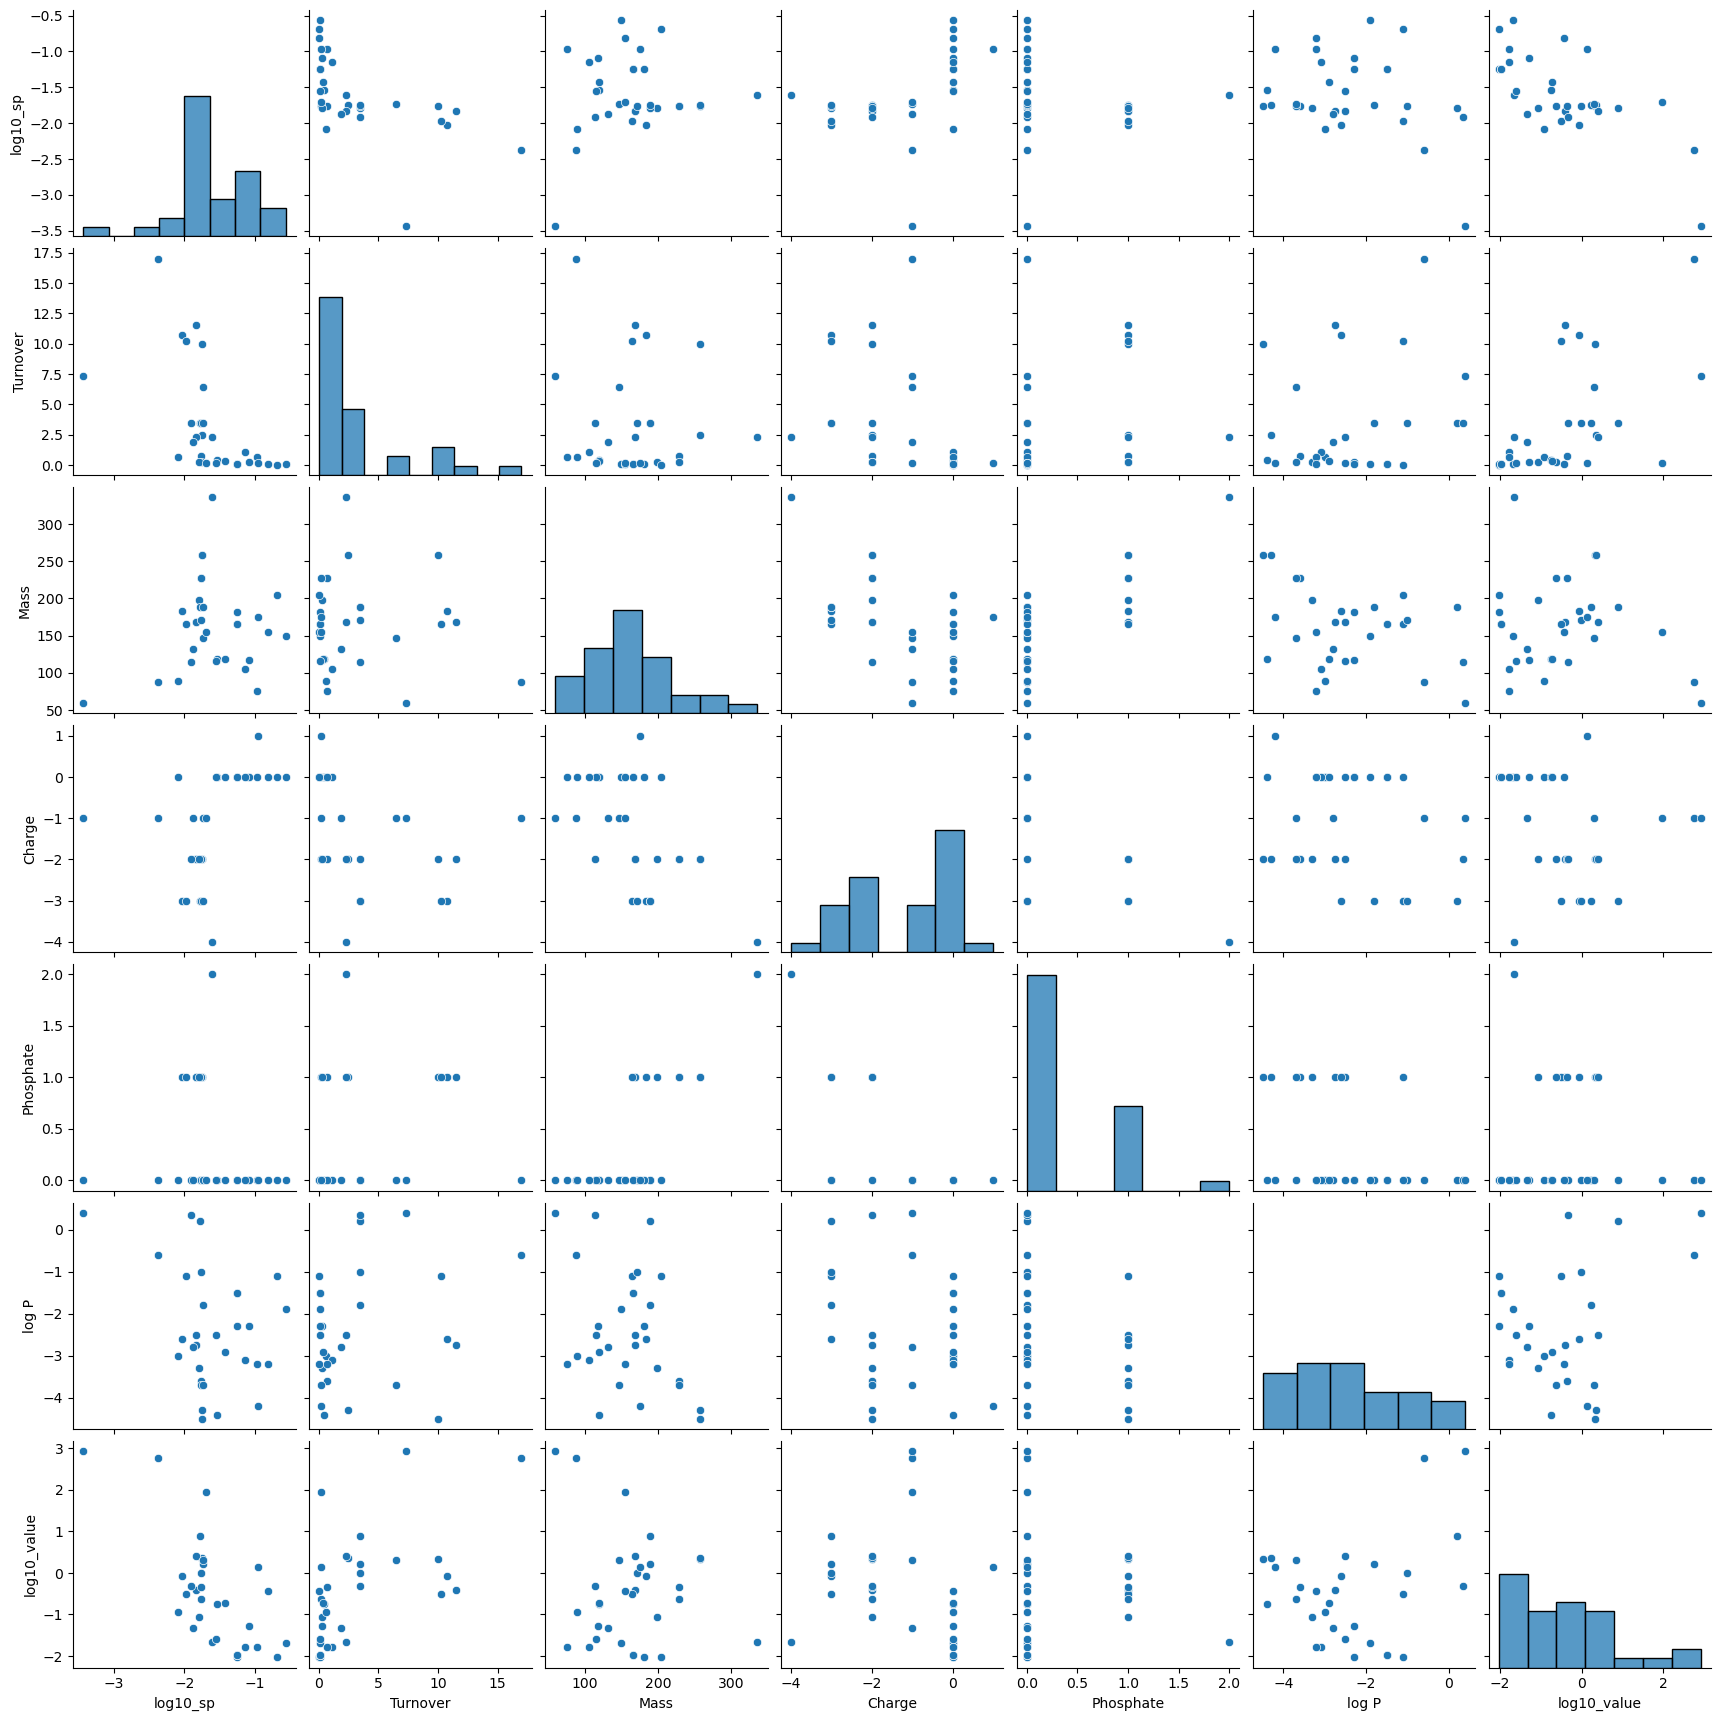

In [100]:
sns.pairplot(df[columns+['log10_value']])
plt.show()

In [127]:
for c in columns:
    sns.lmplot(data = df, x = c, y = 'log10_value')

    r, p = sp.stats.pearsonr(df.loc[:,c], df.loc[:,'log10_value'])
    print(c, r, p)

/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


log10_sp -0.6963669389300289 6.7737965943131815e-06
Turnover 0.5728699842998429 0.0004935090112129087
Mass -0.14670512342207198 0.41525362556858425
Charge -0.30038786412853824 0.08940571100314225
Phosphate -0.009916681697665276 0.9563203528657679
log P 0.3448831461978893 0.04934612740275282


## Make train and test set

In [108]:
data = StandardScaler().fit_transform(df[columns])
X_train, X_test, y_train, y_test = train_test_split(data, df.log10_value, test_size=0.1)#, random_state=40)


In [109]:
N = 100
coefficients = np.zeros((6,N))*np.nan

R2_arr = np.zeros(N)
R2_arr_test = np.zeros(N)
data = StandardScaler().fit_transform(df[columns])

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(data, df.log10_value, test_size=0.05)
    linear_reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)
    coefficients[:, i] = linear_reg.coef_
    R2_arr[i] = linear_reg.score(X_train, y_train)


In [103]:
len(coefficients.mean(axis = 1)), len(columns)

(6, 6)

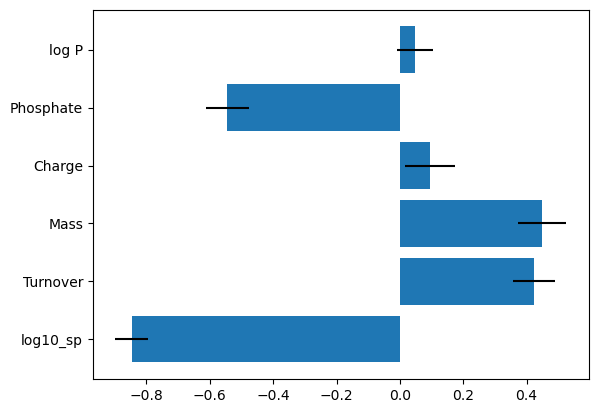

In [113]:
plt.barh(columns, coefficients.mean(axis=1), xerr = coefficients.std(axis=1))
plt.show()

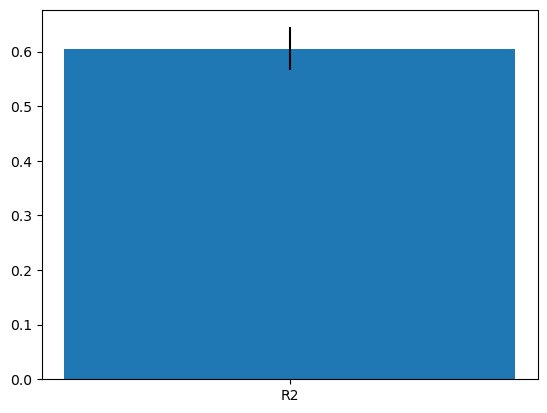

In [114]:
plt.bar(["R2"], [R2_arr.mean()], yerr = [R2_arr.std()])
plt.show()

In [ ]:
plt.plot()

# Test multiple different linear models

In [316]:
columns = ["log10_sp"]#, "log10_conc", "Turnover", "Mass", "Charge", "Phosphate", 'log P']#"Concentration", "Shadow price", 


In [318]:
all_sets = [list(x) for x in utils.powerset(columns) if len(x)]

In [319]:
all_sets[-10:]

[['log10_sp']]

In [320]:
def adj_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

In [1]:
R2_mean = np.zeros(len(all_sets))
R2_adj = np.zeros(len(all_sets))
R2_std = np.zeros(len(all_sets))
loo = LeaveOneOut()

for i, model in enumerate(all_sets):
    temp_arr = np.zeros(data.shape[0])
    data = StandardScaler().fit_transform(df[model])
    for j, (train_index, test_index) in enumerate(loo.split(data)):
        X = data[train_index, :]
        y =  df.log10_value.values[train_index]
        linear_reg = LinearRegression(fit_intercept = True).fit(X, y)
        #coefficients[:, i] = linear_reg.coef_
        temp_arr[j] = linear_reg.score(X, y)
    R2_mean[i] = temp_arr.mean()
    R2_adj[i] = adj_r2(temp_arr.mean(), len(temp_arr), len(model))
    R2_std[i] = temp_arr.std()

NameError: name 'np' is not defined

In [322]:
idx = R2_mean.argsort()

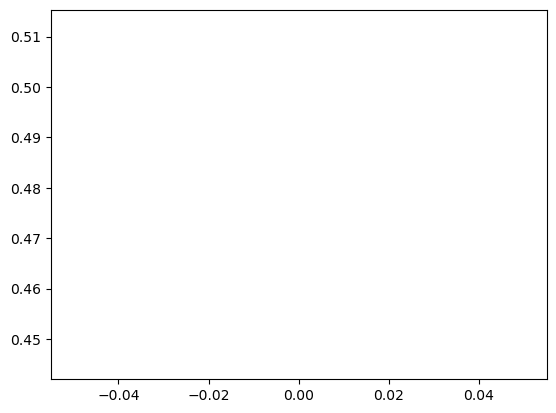

In [324]:
plt.plot(np.arange(len(idx)), R2_mean[idx])
plt.fill_between(np.arange(len(idx)), R2_mean[idx]-R2_std[idx], R2_mean[idx]+R2_std[idx], alpha = 0.5)

# Statsmodels

In [150]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Look at correlation between variables

In [346]:
# columns =  ["Turnover", "Mass", "Charge", "Phosphate", "Topological Polar Surface Area [Å]","log10_sp", "log10_conc", "Shadow price", "Concentration"]
# columns =  ["log10_sp", "Charge"] #"log10_value" "Topological Polar Surface Area [Å]", 
data = StandardScaler().fit_transform(df[columns])

In [326]:
df_i = df[columns]
rho = df_i.corr()
pval = df_i.corr(method=lambda x, y: st.pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

,log10_sp
log10_sp,1.0***


In [327]:
pval

,log10_sp
log10_sp,0.0


In [337]:
data = sm.add_constant(data)

In [348]:
y = StandardScaler().fit_transform(df.log10_value.values[:, np.newaxis])

In [340]:
y.std()

1.0000000000000002

In [349]:
ols_model = sm.OLS(y, data)

In [350]:
results = ols_model.fit()

In [351]:
df[columns].columns

Index(['log10_sp'], dtype='object')

In [352]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.479
Model:                            OLS   Adj. R-squared (uncentered):              0.462
Method:                 Least Squares   F-statistic:                              27.63
Date:                Mon, 03 Apr 2023   Prob (F-statistic):                    1.13e-05
Time:                        23:12:49   Log-Likelihood:                         -33.869
No. Observations:                  31   AIC:                                      69.74
Df Residuals:                      30   BIC:                                      71.17
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Define function to estimate confidence intervals

## Linear model

In [395]:
data = StandardScaler().fit_transform(df[columns])
X_train, X_test, y_train, y_test = train_test_split(data, df.log10_value, test_size=0.2)#, random_state=40)

linear_reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)

In [396]:
lin_pred = linear_reg.predict(X_test)

In [397]:
print(linear_reg.score(X_train, y_train))
print(linear_reg.score(X_test, y_test))

0.607237810400629
0.29233524187338844


<BarContainer object of 6 artists>

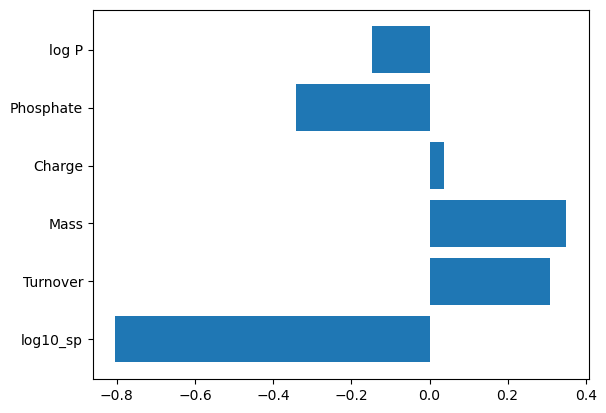

In [398]:
plt.barh(columns , linear_reg.coef_)

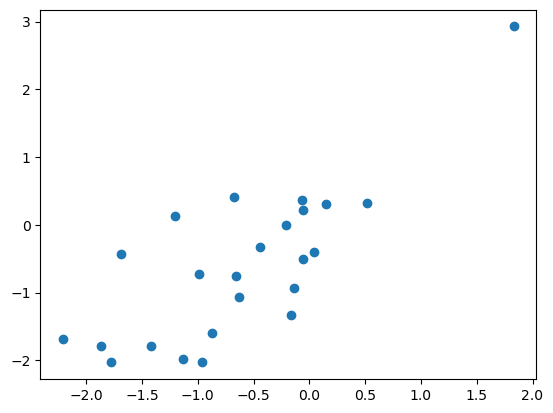

In [399]:
plt.scatter(linear_reg.predict(X_train), y_train)

## Lasso

In [400]:
lasso_reg = Lasso(fit_intercept = True, alpha = 0.01).fit(X_train, y_train)

In [401]:
print(lasso_reg.score(X_train, y_train))
print(lasso_reg.score(X_test, y_test))

0.6050865316327687
0.25714633345381777


<BarContainer object of 6 artists>

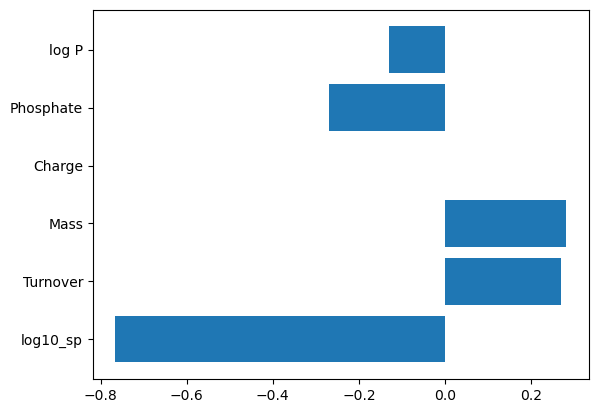

In [402]:
plt.barh(columns , lasso_reg.coef_)

# Elastic net

In [403]:
EN_reg = ElasticNet(alpha = 0.001).fit(X_train, y_train)

In [404]:
EN_pred = EN_reg.predict(X_test)
print(EN_reg.score(X_train, y_train))
print(EN_reg.score(X_test, y_test))

0.6072274331911987
0.29000674688294037


<BarContainer object of 6 artists>

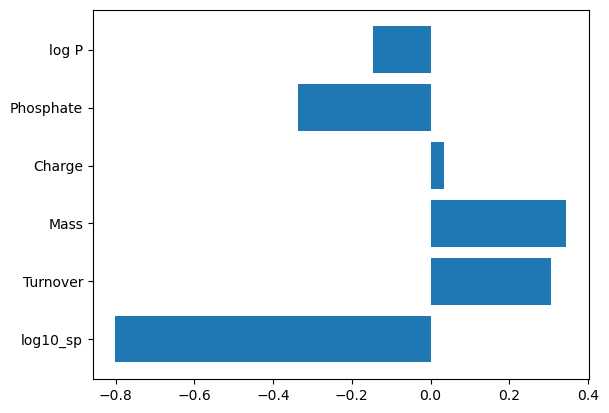

In [405]:
plt.barh(columns , EN_reg.coef_)

## Random forest

In [406]:
rf_reg = RandomForestRegressor().fit(X_train, y_train)

In [407]:
rf_pred = rf_reg.predict(X_test)

In [408]:
print(rf_reg.score(X_train, y_train))
print(rf_reg.score(X_test, y_test))

0.9197807221166385
-0.451585196644662


RandomForestRegressor()

## Decision tree

In [378]:
tree_reg = tree.DecisionTreeRegressor().fit(X_train, y_train)

In [379]:
tree_pred = tree_reg.predict(X_test)

In [380]:
print(tree_reg.score(X_train, y_train))
print(tree_reg.score(X_test, y_test))

1.0
-0.40784768564515095


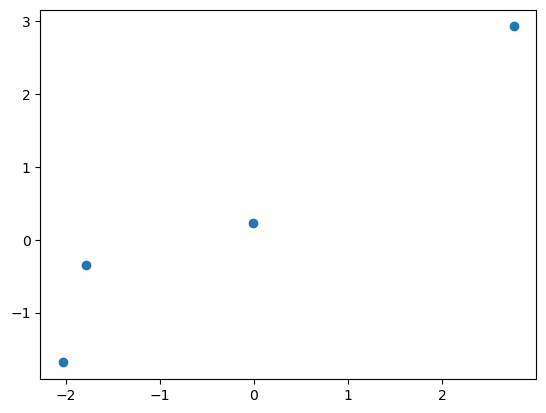

In [310]:
plt.scatter(tree_pred, y_test)

In [311]:
ard_reg = BayesianRidge(alpha_init=0.1, lambda_init=0.01).fit(X_train, y_train)

In [312]:
print(ard_reg.score(X_train, y_train))
print(ard_reg.score(X_test, y_test))

0.49019175016526784
0.7275372934361742


In [313]:
from sklearn.neural_network import MLPRegressor

In [314]:
MLP_reg = MLPRegressor(max_iter = 1000).fit(X_train, y_train)

In [315]:
print(MLP_reg.score(X_train, y_train))
print(MLP_reg.score(X_test, y_test))

0.9760784223482319
0.9109427355453426


[array([[ 0.18013351, -0.18151567,  0.12642034, -0.05617019,  0.00987986,
          0.00731731,  0.15084528,  0.09732818,  0.09153956, -0.07128596,
          0.25849024, -0.23289872, -0.04644276, -0.01279582,  0.15689094,
          0.31508104, -0.01638097,  0.30301362, -0.01731219, -0.18855022,
          0.17952468, -0.09144234, -0.19555564, -0.12586062,  0.15982066,
          0.1345942 ,  0.18493138,  0.23957611,  0.00478899, -0.03106493,
          0.17839147, -0.02238844,  0.31277231, -0.14683018,  0.09904009,
         -0.00179072, -0.17942071, -0.05809929,  0.12016301, -0.12260145,
          0.07941516,  0.04842748, -0.1038866 ,  0.09002151,  0.26457866,
         -0.1043415 , -0.06652327, -0.11799308, -0.30485799, -0.04079448,
          0.09851252, -0.1716397 , -0.00731401, -0.23605771, -0.06021398,
         -0.01207341, -0.11827515, -0.15948293, -0.09148907, -0.07882032,
         -0.046759  , -0.23048956,  0.11800451, -0.18926228,  0.10650232,
         -0.17340069,  0.00392482, -0.